# Project 1

## Exploratory data analysis and preprocessing

The **exploratory data analysis** is the statistical treatment to which the samples collected during a research process in any scientific field are subjected.
For greater speed and accuracy, the entire process is usually carried out by computer, with specific applications for statistical treatment.

### Application to Data Mining

In **data mining**, although not mandatory, it is a good practice to analyze the data you will be working with in order to observe its main characteristics in order to get an idea of the structure of the data set, and identify the target variable and possible modeling techniques.

**Basic Process**
- *Transform the data*: It helps us know what to do with null, missing values, or atypical data. In addition, it establishes if there is a need to reduce the dimensionality of data.
- *Visualize*: Use some tool to make a graphical representation of the data, for example, R, Jupyter notebook, Google Colab, etc.
- *Analyze and interpret*: Analyze and interpret the data through different visualizations.
- *Document*: Document all the graphs and statistics generated.

This process is also helpful when reviewing the data description to understand the meaning of each characteristic.

There are several activities in doing an exploratory data analysis but in terms of data mining the key points to be made are:

- Description of the data structure.
- Identification of missing data.
- Detection of outliers.
- Identification of relationships between variable pairs.

The **goal of this project** is to learn how to do data exploration. In this case, data from **New York City Yellow Taxis** is used.

At the end of the notebook, you should be able to answer the following question:


## How has covid affected the use of taxis in New York?

Some of the questions you will ask yourselves throughout the notebook are:
- How has covid changed the use of taxis in NYC?
- What pick-up distribution do the taxis follow and what distance / duration do they take?
- What are the areas where taxis are picked up the least? And where else do people go?
- What are the most usual times?
- Which days of the week and month are used the most? Possible reasons?

**Install and import the required libraries**

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [6]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Global variables

YEARS = [2019, 2020, 2021]

First of all, you need to download the data:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [8]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

  0%|          | 0/3 [00:00<?, ?it/s]

## 01. Data cleaning

In order to have clean and useful data, it is necessary to delete all those rows that contain corrupt information:
- The pick-up is after the drop-off.
- Dates are imported by months and years. Are the dates correct?
- Traveling with zero passengers?
- Do you travel very long or particularly short?
- Negative payments.

**Data Dictionary**

Only the next columns are needed:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Remarks:**

- To speed up the calculations and reduce the computation time, do a uniform sampling of the data (a sample out of 1000).
- Datetime columns are *to_datetime* series (help to search functions)

In [9]:
def load_table(year, month):
    """
    Function that reads the downloaded data and converts it to a DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [10]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 
                 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Function that clears the month data.
    """
    
    # HERE YOUR CODE
    
    # Los :: permite tomar aleatoriamente de cada n elementos 1 fila, si usamos solo : estaremos tomando los primeros n 
    # y podriamos entrar en el error de tomar los primeros días del mes ademas que solo tomaría n elementos, con :: tomamos
    # una fila de cada n elementos y asi sucesivamente
    
    data = data[::sampling]
    data = data[required_data]
    data=data[data.tpep_pickup_datetime<data.tpep_dropoff_datetime] # Eliminar fechas donde el inicio es mayor que el fin
    data=data[data.passenger_count>0] #Eliminar pasajeros negativos y ceros
    data=data[np.logical_not(np.isnan(data.passenger_count))] #Eliminar los nan usando funciones np.logical_
    data = data[data.total_amount>0] # Eliminar pagos negativos
    data = data[data.fare_amount>0] # Eliminar tarifas negativas
    data = data[data.trip_distance>0] # Eliminar viajes con distancia en cero o negativo
    data=data[(data.tpep_dropoff_datetime.dt.year==year) & (data.tpep_dropoff_datetime.dt.month==month)]
    data=data[(data.tpep_pickup_datetime.dt.year==year) & (data.tpep_pickup_datetime.dt.month==month)]
    data['year']=year
    
    return data
    
#     raise NotImplementedError

In the ***post_processing*** function you can add all information you need in order to perform the necessary exploration.

In [11]:
def post_processing(data):
    """
    Function to implement any type of post-processing required.
    """
    data['trip_distance'] = data['trip_distance']*1.6
#     data = data[data.trip_distance<=50] # I evaluated in the chapter 8.Curiosity killed the cat
    data['pickup_month'] = data.tpep_pickup_datetime.dt.month
    data['dropoff_month'] = data.tpep_dropoff_datetime.dt.month
    data['pickup_week'] = data.tpep_pickup_datetime.dt.week
    data['dropoff_week'] = data.tpep_dropoff_datetime.dt.week
    data['pickup_hour'] = data.tpep_pickup_datetime.dt.hour
    data['dropoff_hour'] = data.tpep_dropoff_datetime.dt.hour
    data['pickup_day'] = data.tpep_pickup_datetime.dt.weekday
    data['dropoff_day'] = data.tpep_dropoff_datetime.dt.weekday
    data['trip_duration']=pd.to_datetime(data.tpep_dropoff_datetime)-pd.to_datetime(data.tpep_pickup_datetime)
    data['trip_duration'] = data['trip_duration'].dt.total_seconds()/60 # Minutos
#     data = data[data.trip_duration<(200-17.83)/2] # I evaluated in the chapter 8.Curiosity killed the cat
    df['dropoff_dayofyear']=df.tpep_dropoff_datetime.dt.dayofyear
    df['pickup_dayofyear']=df.tpep_pickup_datetime.dt.dayofyear
    data['speed'] = data['trip_distance']*60/data['trip_duration']
    return data
    
    # HERE YOUR CODE
#     raise NotImplementedError

Create a new dataset that contains all the information for the years: 2019, 2020, and 2021.

Remember that in order to reduce the memory required, you can take a subsample of the data.

In [12]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
df = post_processing(df)
df.shape

C:\Users\Anderson\AppData\Local\Temp\ipykernel_15020\4275600729.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['pickup_week'] = data.tpep_pickup_datetime.dt.week
C:\Users\Anderson\AppData\Local\Temp\ipykernel_15020\4275600729.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['dropoff_week'] = data.tpep_dropoff_datetime.dt.week


(132833, 22)

In [14]:
df.head(2)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,dropoff_week,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_duration,dropoff_dayofyear,pickup_dayofyear,speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,1,1,0,0,1,1,6.666667,1,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,...,1,1,0,1,1,1,8.116667,1,1,22.590554


## 02. Visualizations (by years)

### Number of trips by year

Can you answer the question: **Has covid increased / decreased the number of trips made by taxis?**

To answer this question, create a bar figure showing the number of trips per year.

In [15]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    A function that creates a bar figure from the dataframe *df* and the content of the *column* that contains the information.
    """
    
    # Function np.unique() devuelve valores unicos de un arreglo o lista, también puede decirte la frecuencia
    x , h = np.unique(df['year'], return_counts=True)
    # plt.bar(*np.unique(df['year'], return_counts=True)) el * hace de destructuración es lo mismo que x,h
    # Usamos las librerias de matplotlib.pyplot para graficar la cantidad de viajes por año
    plt.bar(x,h)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    
    plt.xticks(YEARS) #Permite agrupar y colocar solo los años exactos 2019,2020,2021 y no 2019,2019.5,2020,2020.5
    # HERE YOUR CODE
#     raise NotImplementedError

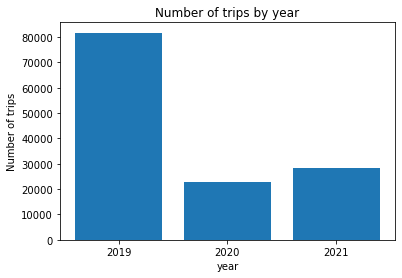

In [16]:
bar_plot(df, 'year', 'year', 'Number of trips', 'Number of trips by year')

**Question: Is this the behavior you expected? Why?**

> ANSWER

> According to the information in the bar chart, we can see that Covid decreased trips between 2019 and 2020 with 6000 trips approx. However, we can infer that with the support of the measures and vaccines, we see an increase between 2020 and 2021.

Now, you will visualize **how many passengers there are per taxi and per year**.

Create a figure with three subplots (one per year) where can be seen the number of passengers per year.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [17]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Function that displays how many passengers there are per taxi and per year
    """
    
    # HERE YOUR CODE
    ### Grafico por los tres años por cada cantidad de pasajeros
    labels = np.unique(df.passenger_count)
    years = np.unique(df.year)
    count_per_year=[]
    if ylabel=='Count':
        count_per_year = [np.unique(df[df.year==year].passenger_count, return_counts=True)[1] for year in years]
    else:
        count_per_year = [np.around((df[df.year==year].groupby('passenger_count').count()/df[df.year==year].count()).year,decimals=2) for year in years]

    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(x-width, count_per_year[0], width, label='2019')
    rects2 = ax.bar(x, count_per_year[1], width, label='2020')
    rects3 = ax.bar(x + width, count_per_year[2], width, label='2021')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x, labels)
    ax.set_ylim(ylim)
    ax.legend()
    

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()

    plt.show()
    
#     raise NotImplementedError

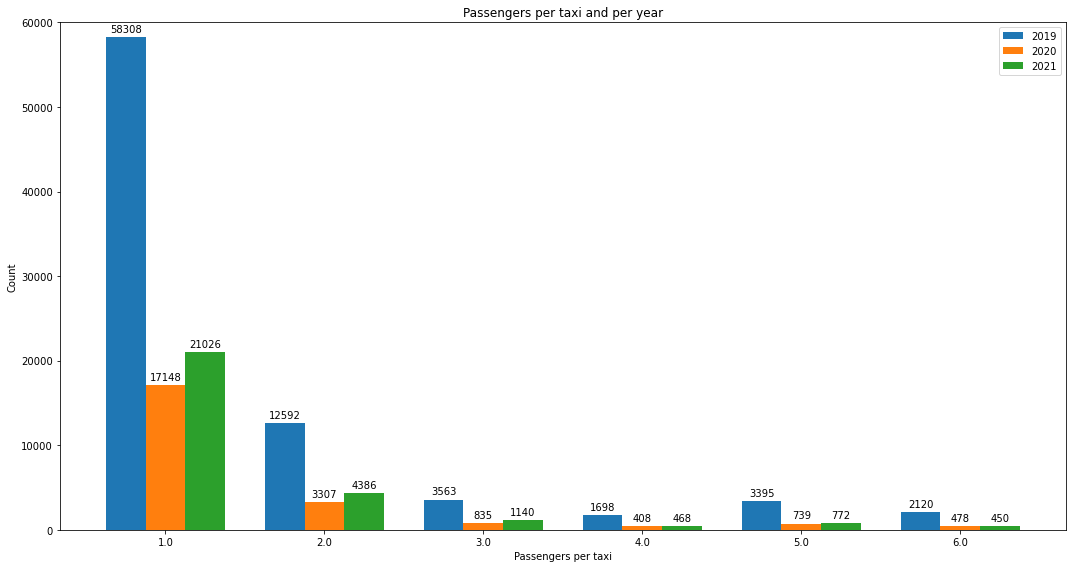

In [18]:
passengers_taxi_year(df, (0, 60000), 'Passengers per taxi', 'Count', 'Passengers per taxi and per year')

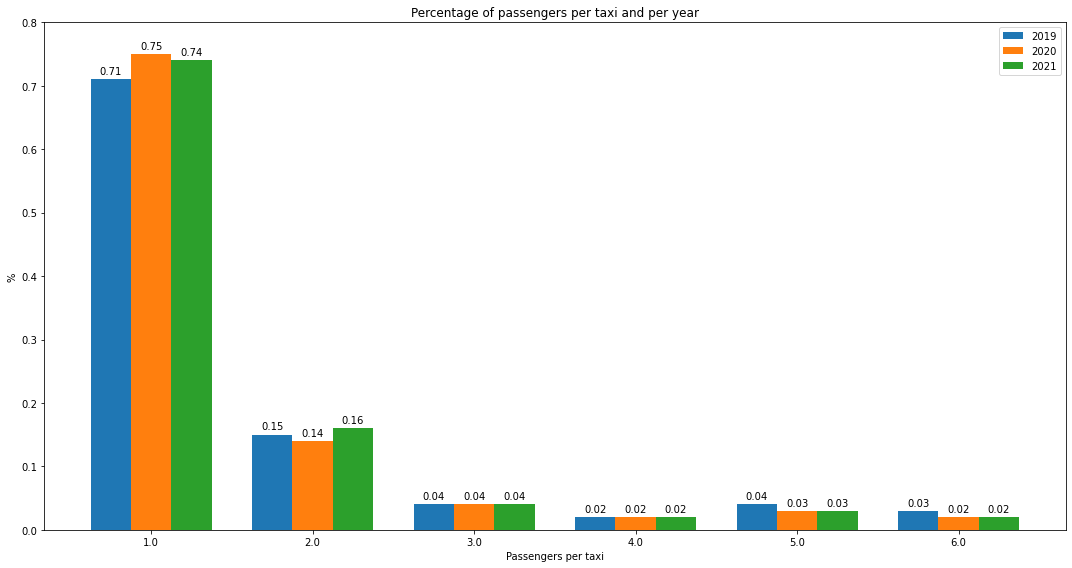

In [19]:
passengers_taxi_year(df, (0, 0.8), 'Passengers per taxi', '%', 'Percentage of passengers per taxi and per year', norm = True)

In the previous figure, you have visualized each year separately. To make the visualization easier to interpret, combine all the information into a graph.

The expected visualization has to contain three columns (different colors) for each number of passengers.

Then repeat the same chart viewing the % (use the *norm* parameter).

In [20]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Function that displays how many passengers there are per taxi
    """
        
    # HERE YOUR CODE
    if ylabel=='Count':
        x , h = np.unique(df['passenger_count'], return_counts=True)
    else:
        x , h = np.unique(df['passenger_count']),np.around((df.groupby('passenger_count').count()*100/df.count()).year,decimals=2)
    plt.figure(figsize=(15, 5))
    p = plt.bar(x,h)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(xlabel)
    
    plt.bar_label(p) # El bar_label permite mostrar los datos exactos en cada barra, pero la variable sale del plt.bar
    
    plt.show()
    
#     raise NotImplementedError

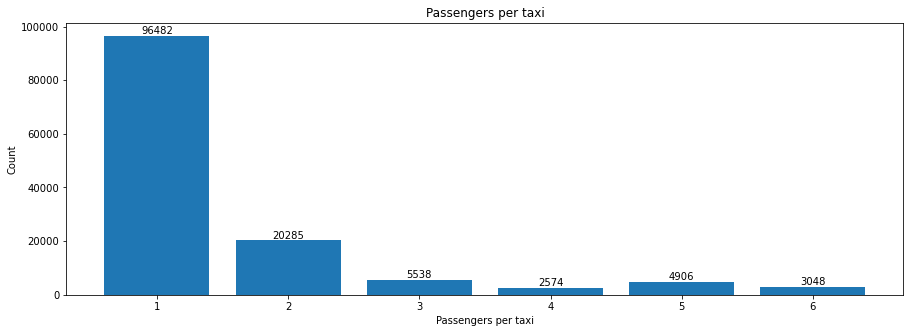

In [21]:
passengers_taxi(df, 'Passengers per taxi', 'Count')

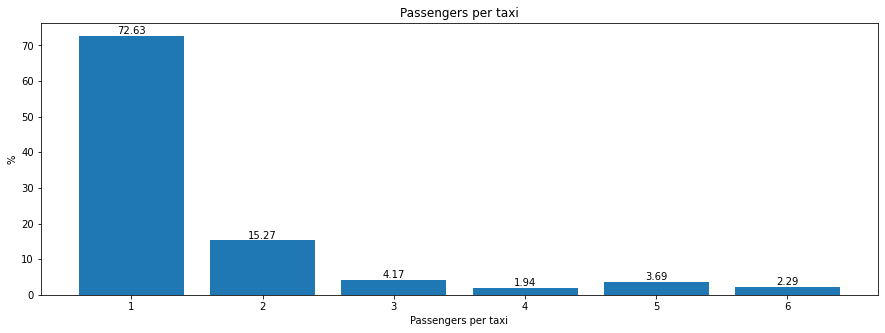

In [22]:
passengers_taxi(df, 'Passengers per taxi', '%', norm = True)

**Question: What impact have you seen on the data? Do you think covid had a lot of impact?**

> ANSWER

> According with the data. We can see the covid effect have impacted in passenger size where 1 passenger per taxi is the biggest

## 03. Number of trips

So far, you have seen the number of trips there have been in the years studied.

Let's study what changes can be seen if you aggregate the data by hours, days of the week, week of the year, and months.


These visualizations have to be done for the *pick-up* and *drop-off* columns. 

Furthermore, the information has to be split by year and represented with dashed lines, and marked with a round or cross wherever the value is.

In [23]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Function that visualizes the number of trips by different data aggregations
    """
    # HERE YOUR CODE
    labels = np.unique(df[columns])    
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    pickup_time = columns[0]
    
    for y in YEARS:
        t,trips_by_time = np.unique(df[df.year==y][pickup_time], return_counts=True)         
        rects1 = ax.plot(t, trips_by_time, label=y,marker="o")
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(labels,step=2)
    ax.legend()

    fig.tight_layout()
    

    plt.show()

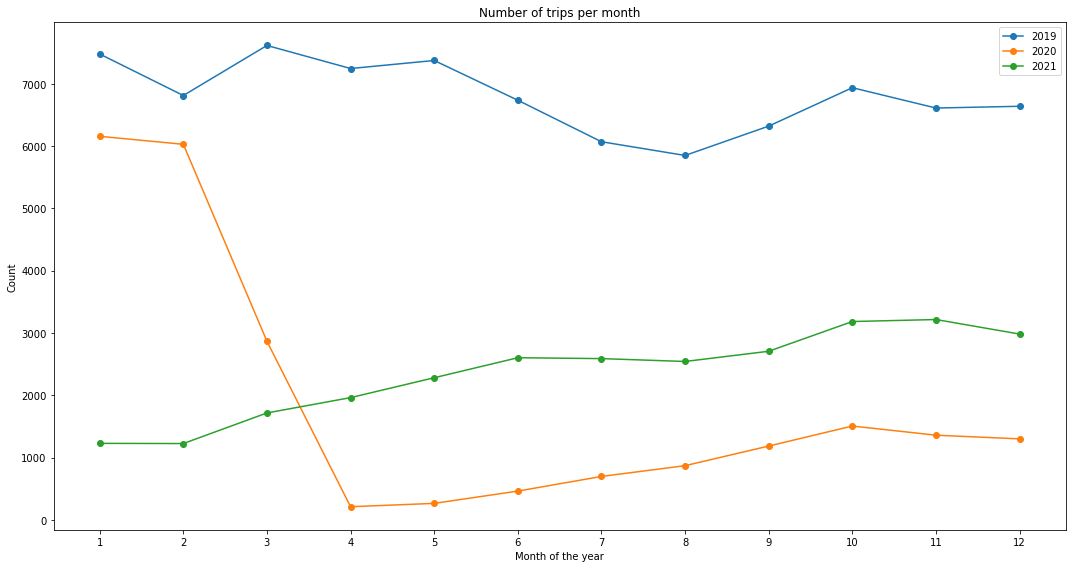

In [24]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Number of trips per month', xlabel = 'Month of the year', ylabel = 'Count')

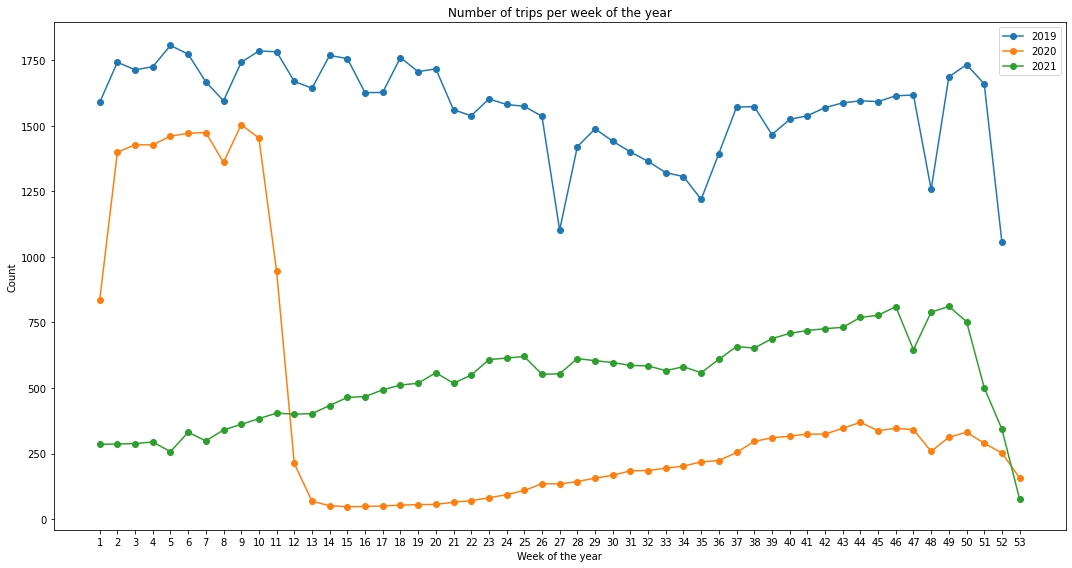

In [25]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Number of trips per week of the year', xlabel = 'Week of the year', ylabel = 'Count')

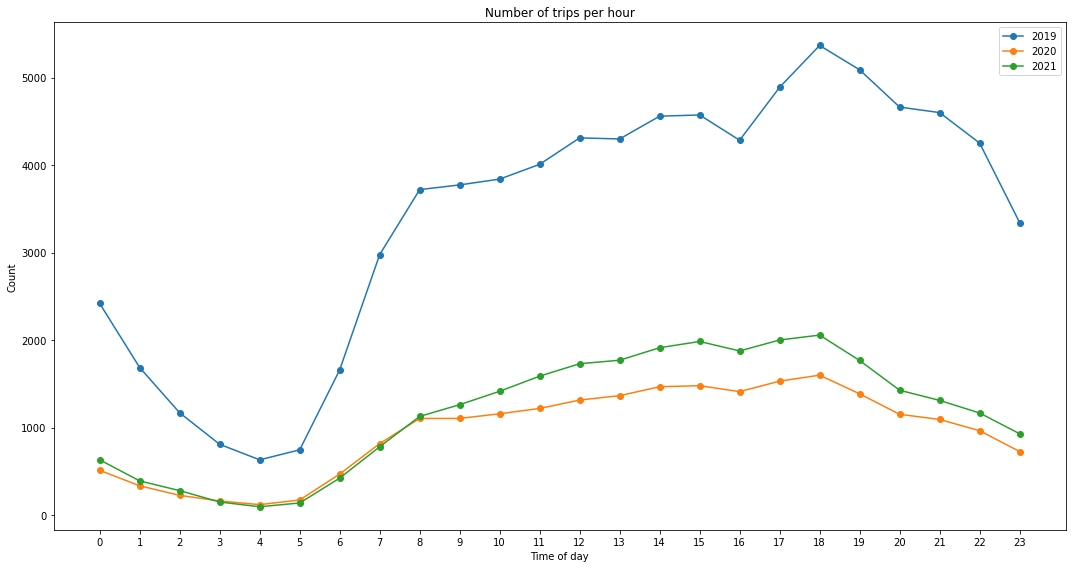

In [26]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Number of trips per hour', xlabel = 'Time of day', ylabel = 'Count')

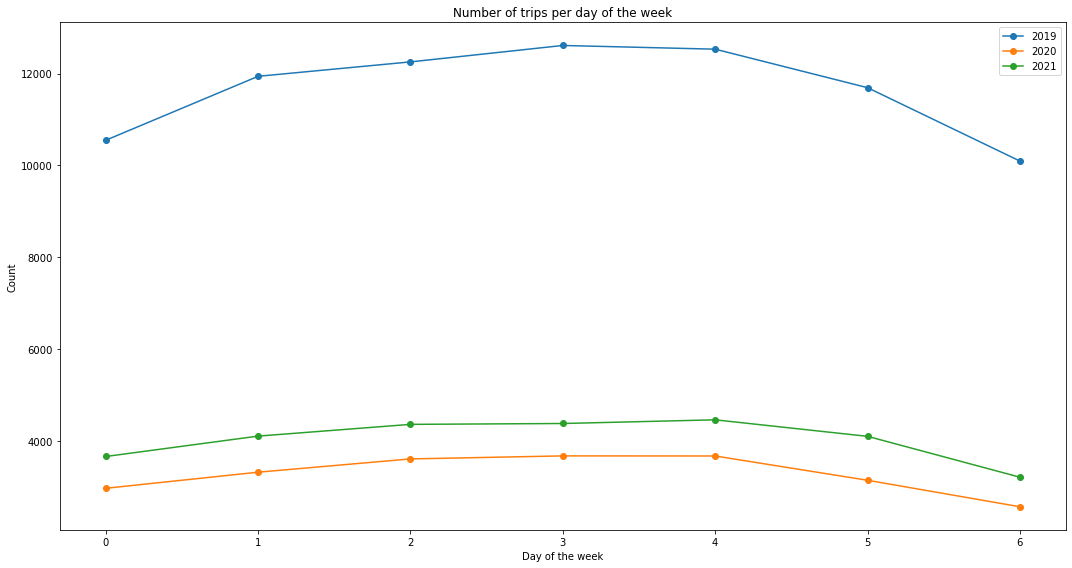

In [27]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Number of trips per day of the week', xlabel = 'Day of the week', ylabel = 'Count')

**Question: What behaviors do you see in each case? What do you think is the reason?**

> ANSWER

## 04. Distance/duration and speed relationship

In the data, there is the distance traveled by taxis on each trip. Furthermore, you can extract the duration of the trips using: *tpep_dropoff_datetime* and *tpep_pickup_datetime*.

Now, you will find out how covid affected the distances and durations of journeys along with the speed of taxis.

Do you think the traffic density changed?

### Histograms

Visualize the **histograms** of distance and duration per year.

You can use *plt.hist()* or *plt.bar()* function.

In [28]:
def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Function that creates a histogram from the information contained in the column *column* of the dataframe *df*
    """
    
    # HERE YOUR CODE
    for y in YEARS:
        plt.figure(figsize=(10, 5))
        if column=='trip_distance':
            n, bins, patches = plt.hist(df[df['year']==y][column], bins = int((xlim[1]-xlim[0])/2)+1, range = (xlim[0], xlim[1])) #density=True normaliza todos los valores y trabaja en frecuencia
        else:
            n, bins, patches = plt.hist(df[df['year']==y][column], bins = int((xlim[1]-xlim[0])/2)+1, range = (xlim[0], xlim[1])) # Range: The lower and upper range of the bins. Lower and upper outliers are ignored.

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        year_text='year='+str(y)
        if column=='trip_distance':
            plt.text(10, 5000, year_text)
        else :
            plt.text(0, 1200, year_text)
        plt.xlim(xlim)
#         plt.bar_label(patches)
    #     plt.ylim(0, 0.03)
        plt.grid(True)
        plt.show()
#     raise NotImplementedError

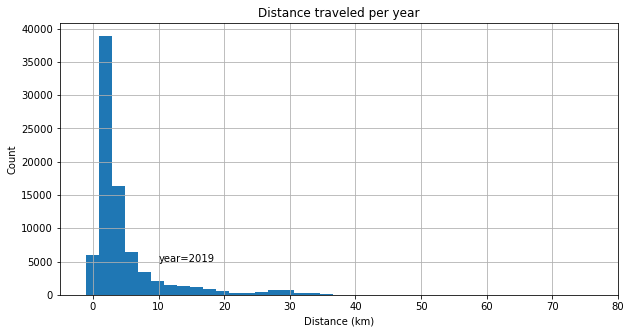

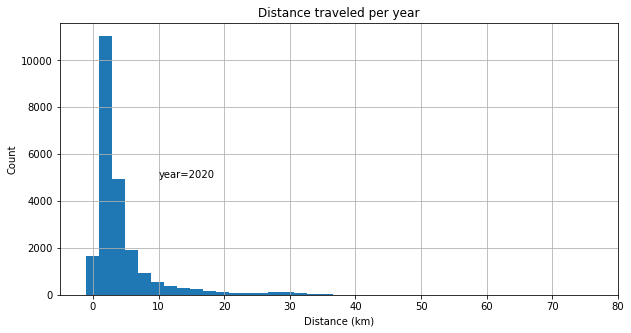

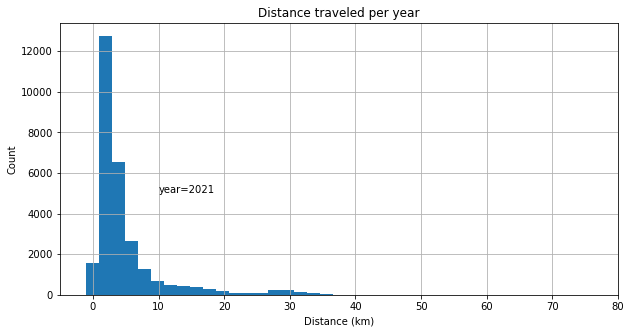

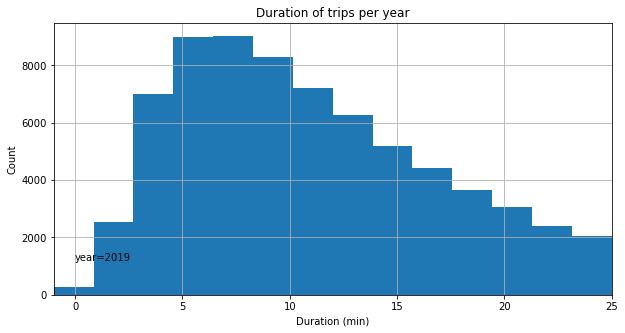

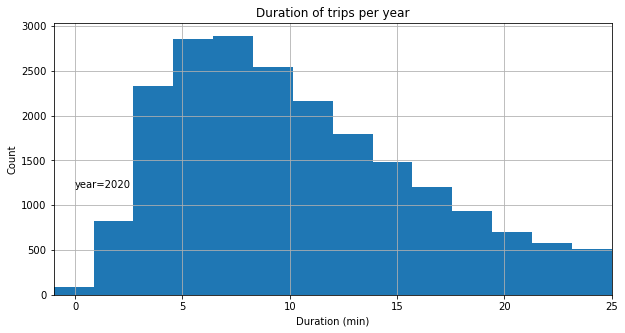

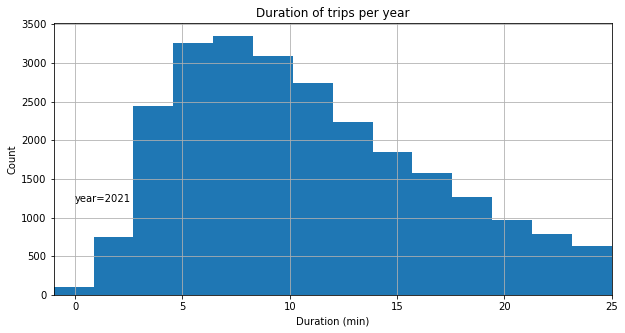

In [29]:
visualize_histograms(df, 'trip_distance', title = 'Distance traveled per year', 
                     xlabel = 'Distance (km)', ylabel = 'Count', xlim = (-5, 80))

visualize_histograms(df, 'trip_duration', title = 'Duration of trips per year', 
                     xlabel = 'Duration (min)', ylabel = 'Count', xlim = (-1, 25) )

**QUESTIONS:**

* How do you think covid affected travel distances and durations?

* And the speed of taxis?

> ANSWER

### Scatter plot and correlation

Create scatter plots to illustrate the relationship between trip duration and distance.

It is possible that the data contain samples outside the distribution (outliers). In this case, skip this samples and display the figure again.

To see if any correlation exists, it is interesting to use the *sns.regplot()* function.

In [30]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Function that displays a scatter plot given the name of the columns that contains the information
    """
    # HERE YOUR CODE
    if remove_outliers:
        std = df[y_value].mad()
        avg = df[y_value].mean()
    
        filtered_data = df.loc[(abs(df[y_value]-avg)) <= (6*std)]
    else:
        filtered_data = df        
    
    for y in YEARS:
        sns.regplot(x = x_value,
                    y = y_value,
                    data = filtered_data[filtered_data.year==y],
                    dropna = True)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title('Time of trip per distance per year '+str(y))
        plt.show()
#     raise NotImplementedError

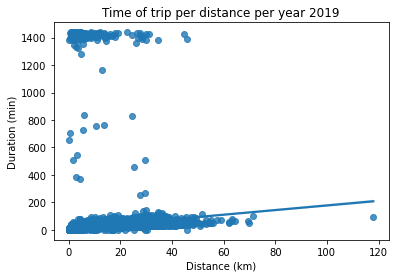

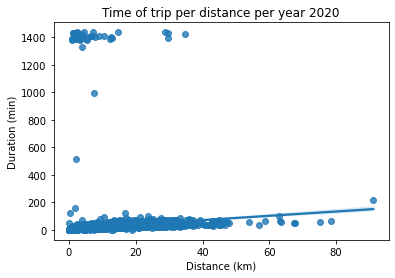

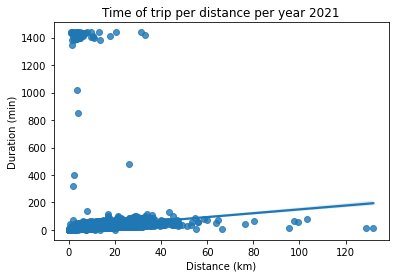

In [31]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (min)')

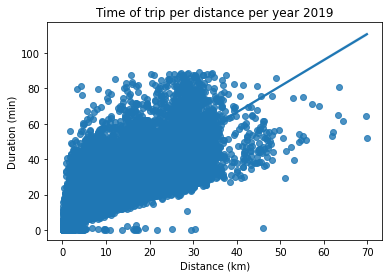

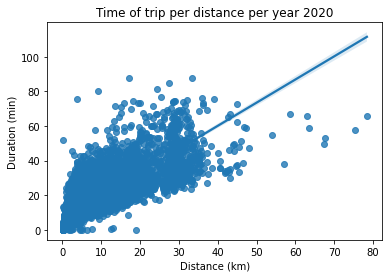

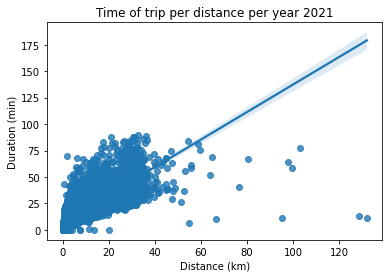

In [32]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distance (km)', 'Duration (min)', True)

**Question: Can you see any relationship? Can you calculate the correlation between the data to get more information?**

> ANSWER

As you did in section 3, visualize the time and distance data for the weeks and months of the year.

In [33]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Function that show the distance / duration of trips in the time determined
    """
    # HERE YOUR CODE
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    pickup_time = columns[0]
    
    for y in YEARS:
        values= df[(df.year==y)].groupby(pickup_time)[column_data].mean()
        rects1 = ax.plot(values, label=y,marker="o")
    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()

    fig.tight_layout()
    

    plt.show()
#     raise NotImplementedError

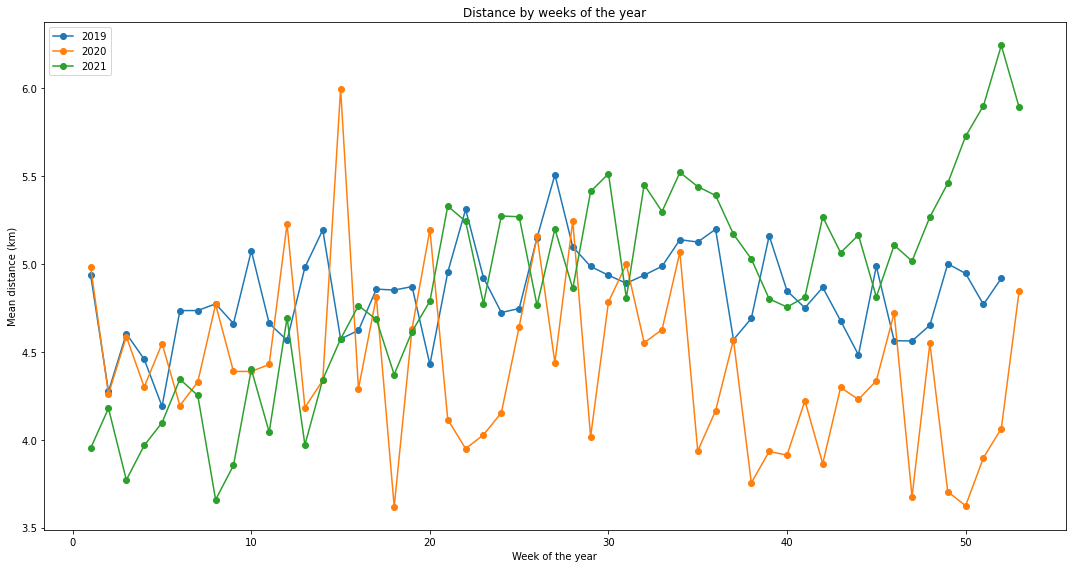

In [34]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Week of the year', ylabel = 'Mean distance (km)', title = 'Distance by weeks of the year')

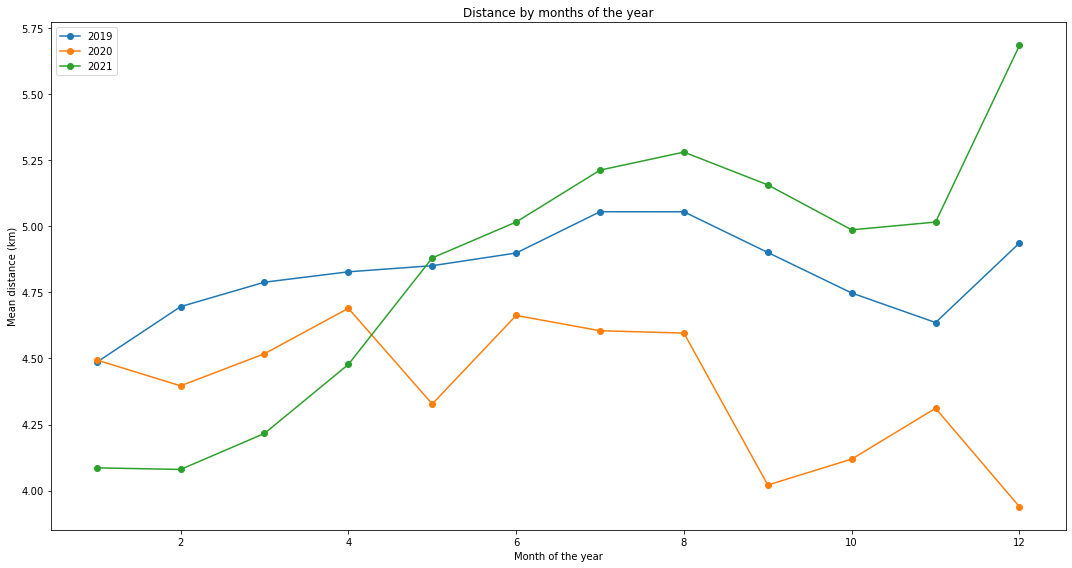

In [35]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean distance (km)', title = 'Distance by months of the year')

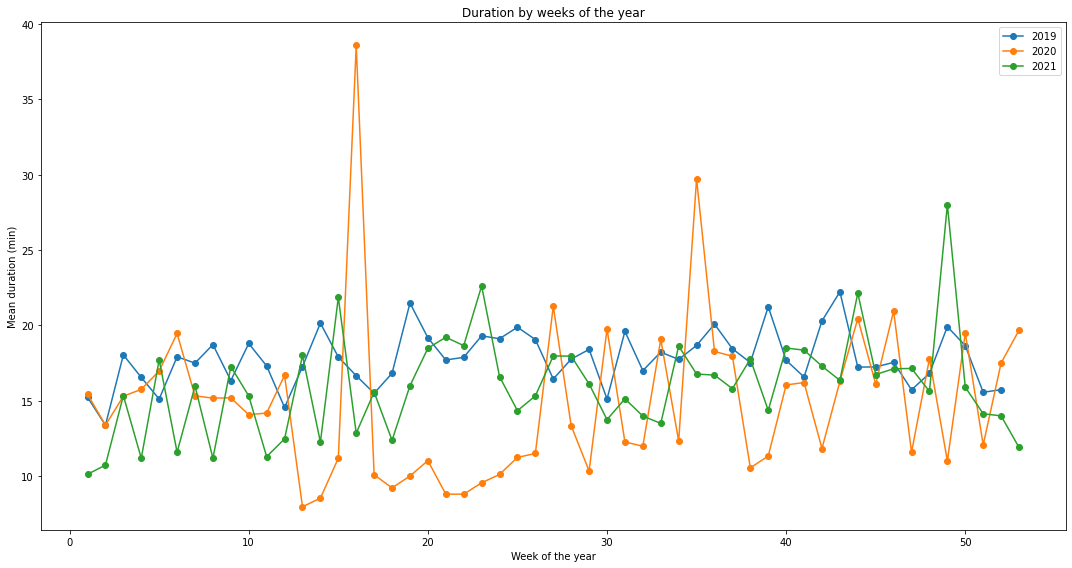

In [36]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Week of the year', ylabel = 'Mean duration (min)', title = 'Duration by weeks of the year')

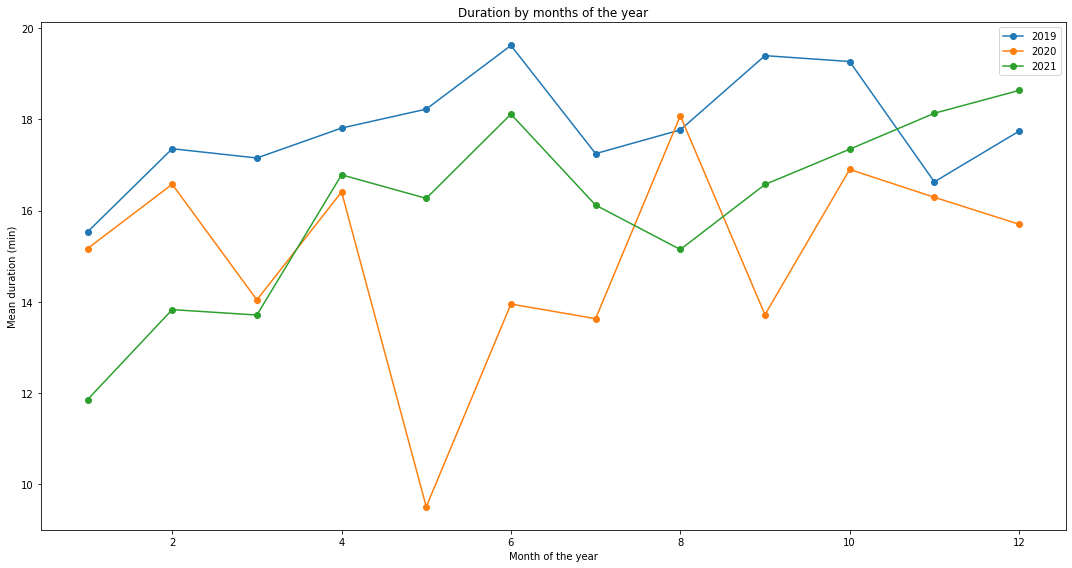

In [37]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Month of the year', ylabel = 'Mean duration (min)', title = 'Duration by months of the year')

**Question: Is there any strange behavior apart from covid? What can it be caused by?**

> ANSWER

So far, you have shown the data by aggregating different information.

Now, you have to visualize the data like images. For that, you will use the *plt.imshow()* function which displays images and arrays.

Implement a function that displays heatmaps by year (each function display 3 heatmaps, one per year):

- a heatmap showing what time of day are the longest trips during the year.
- a heatmap showing what time of day are the longest trips during the week.

In [111]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a heatmap
    """
    
    # HERE YOUR CODE
    for y in YEARS:
        plt.figure(figsize=(35,10))
        df_y = df[df.year==y]
        
        #unstack() convierte a matriz el groupby y fillna completa para fechas que no hay taxi en cero para tener la grafica completa
        values = df_y.groupby(group).mean()[column_data].unstack().fillna(0) 
        im = plt.imshow(values)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        title = 'Heatmap in '+str(y)
        plt.title(title)
        if columns:
            plt.xticks([0,1,2,3,4,5,6], columns, rotation=45)

        plt.colorbar(im)
#     raise NotImplementedError

    # Second Solution
#     fig, axs = plt.subplots(3,1,figsize=(10,8))
#     cont = 0
#     for y in YEARS:
#         ax = axs[cont]
#         df_y = df[df.year==y]

#         #unstack() convierte a matriz el groupby y fillna completa para fechas que no hay taxi en cero para tener la grafica completa
#         values = df_y.groupby(group).mean()[column_data].unstack().fillna(0) 

#         im = ax.imshow(values,aspect='auto')
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel(ylabel)
        
#         cont +=1

#     fig.colorbar(im, ax=axs)
    
#     plt.show()

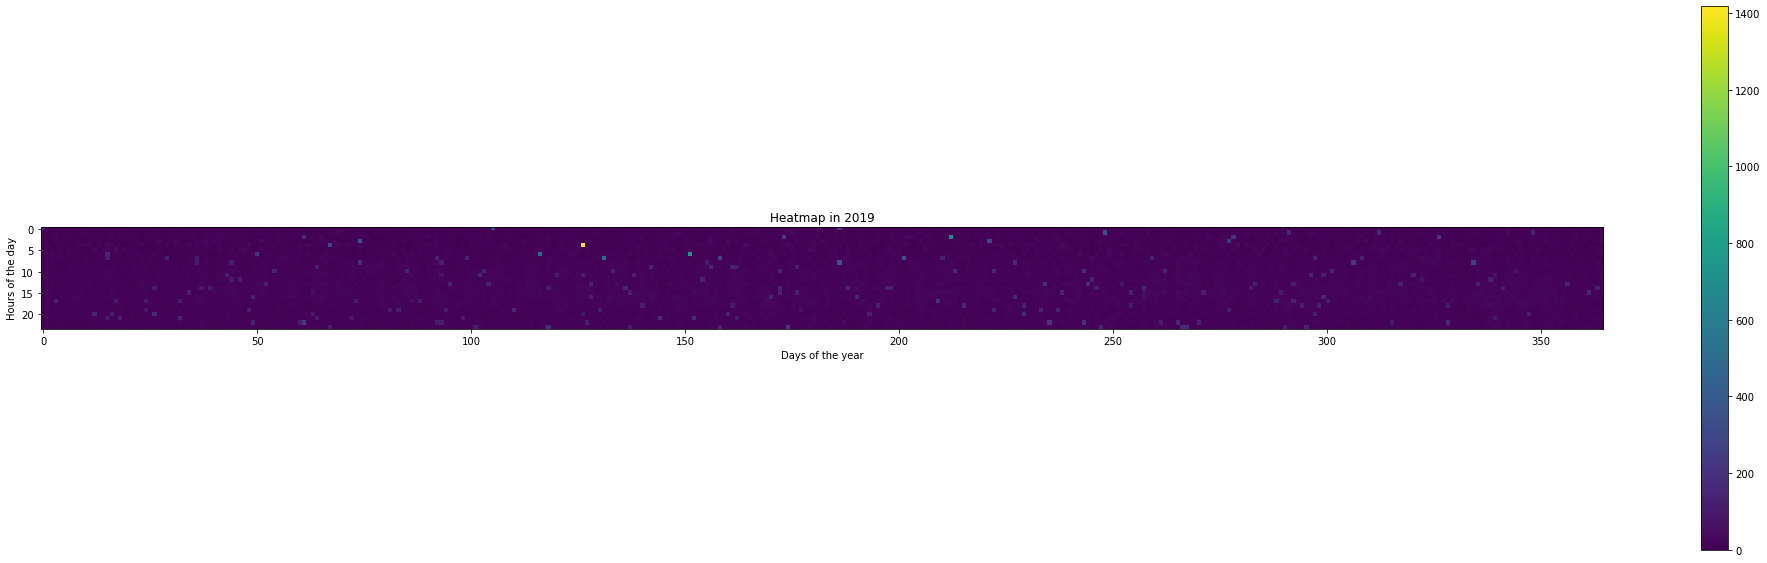

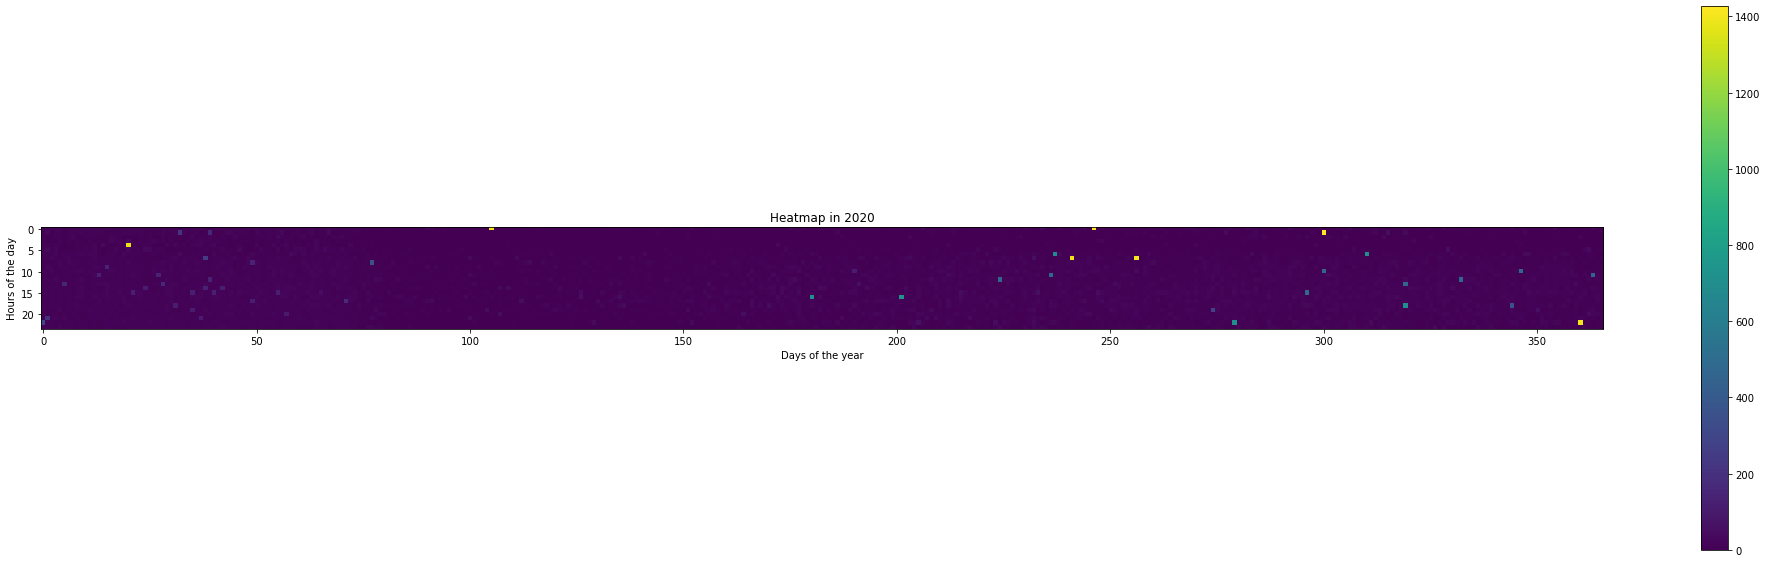

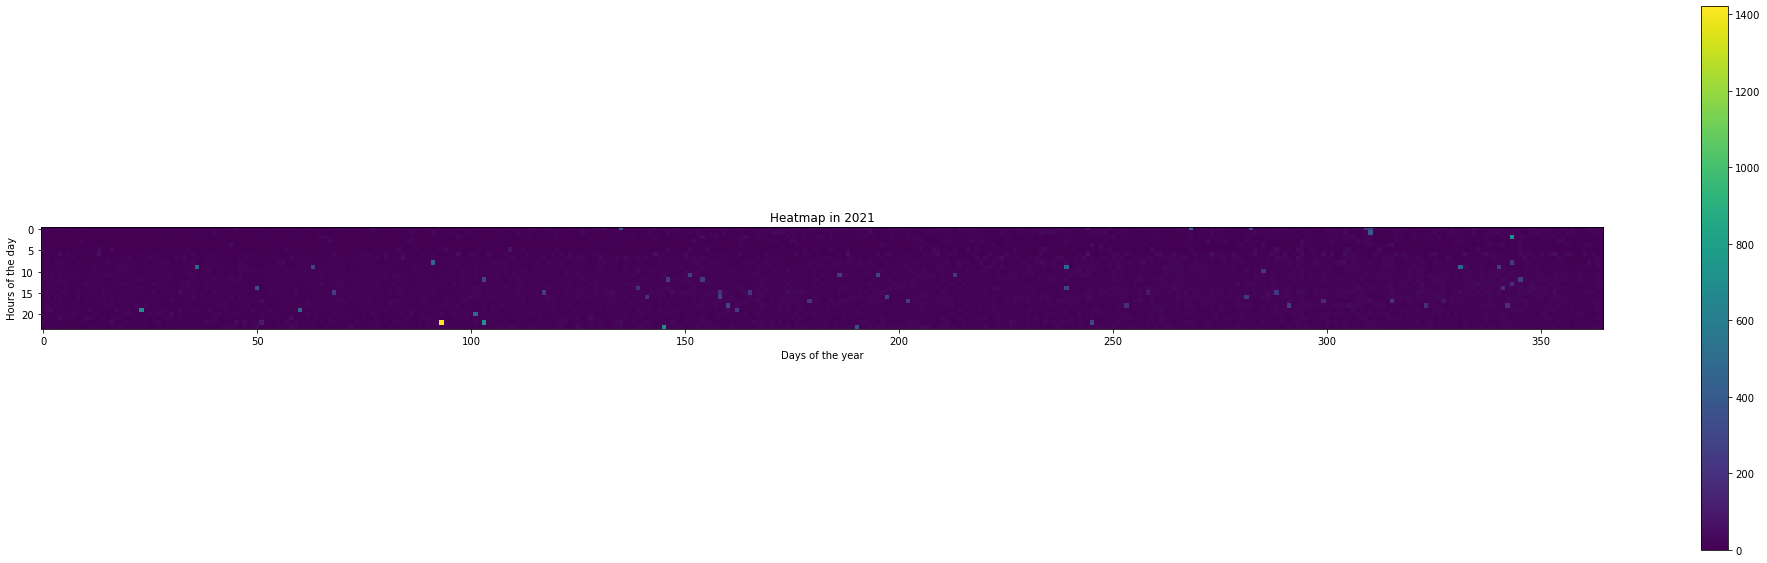

In [112]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_duration', 'Days of the year', 'Hours of the day')

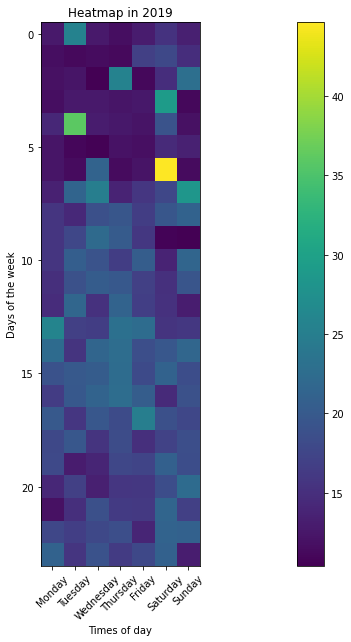

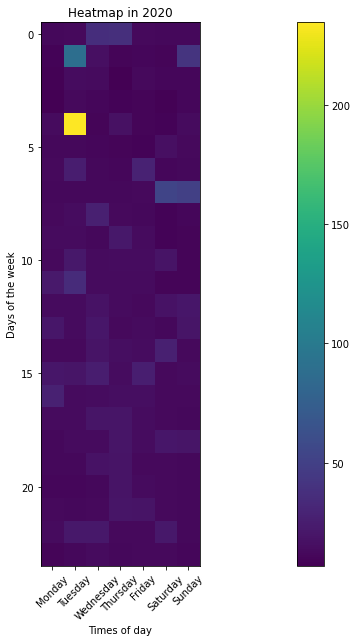

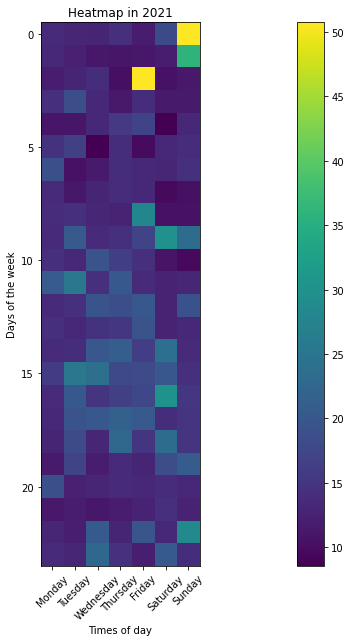

In [70]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Times of day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeat the previous heatmaps visualizing the distance.

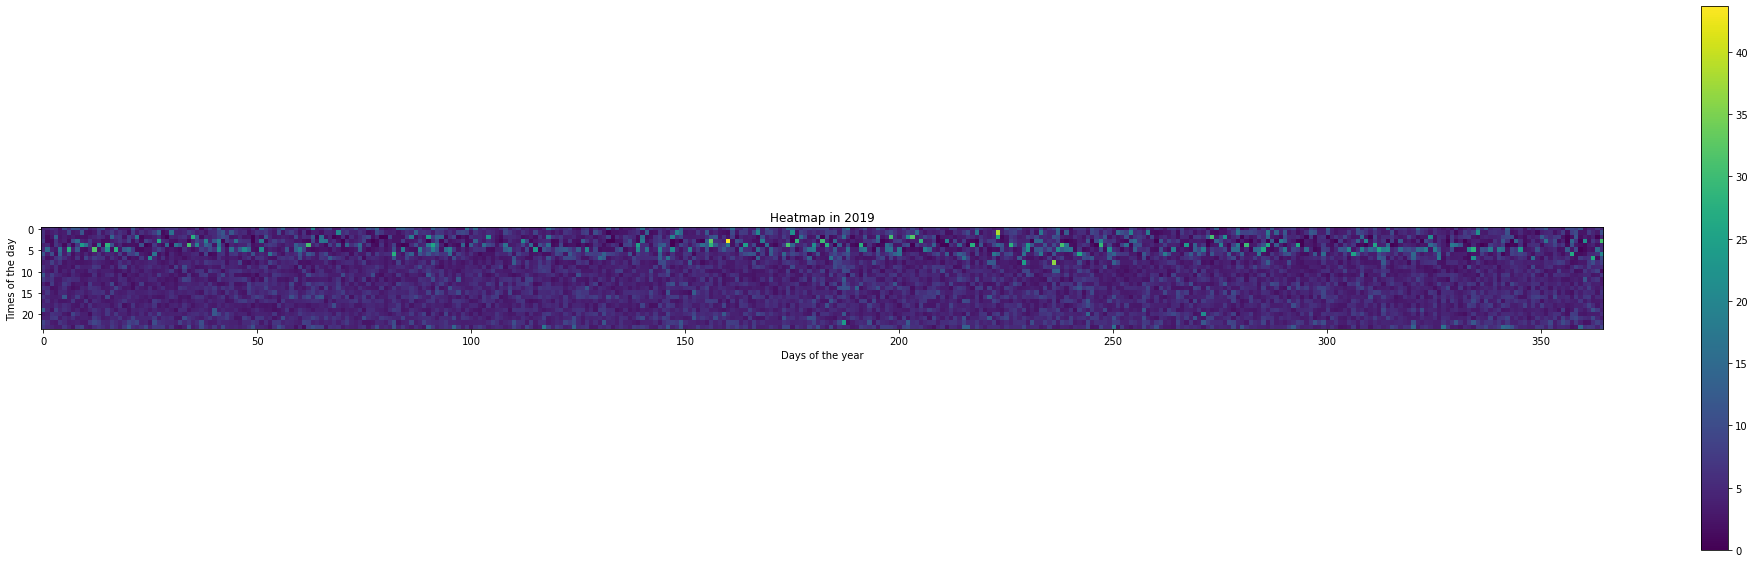

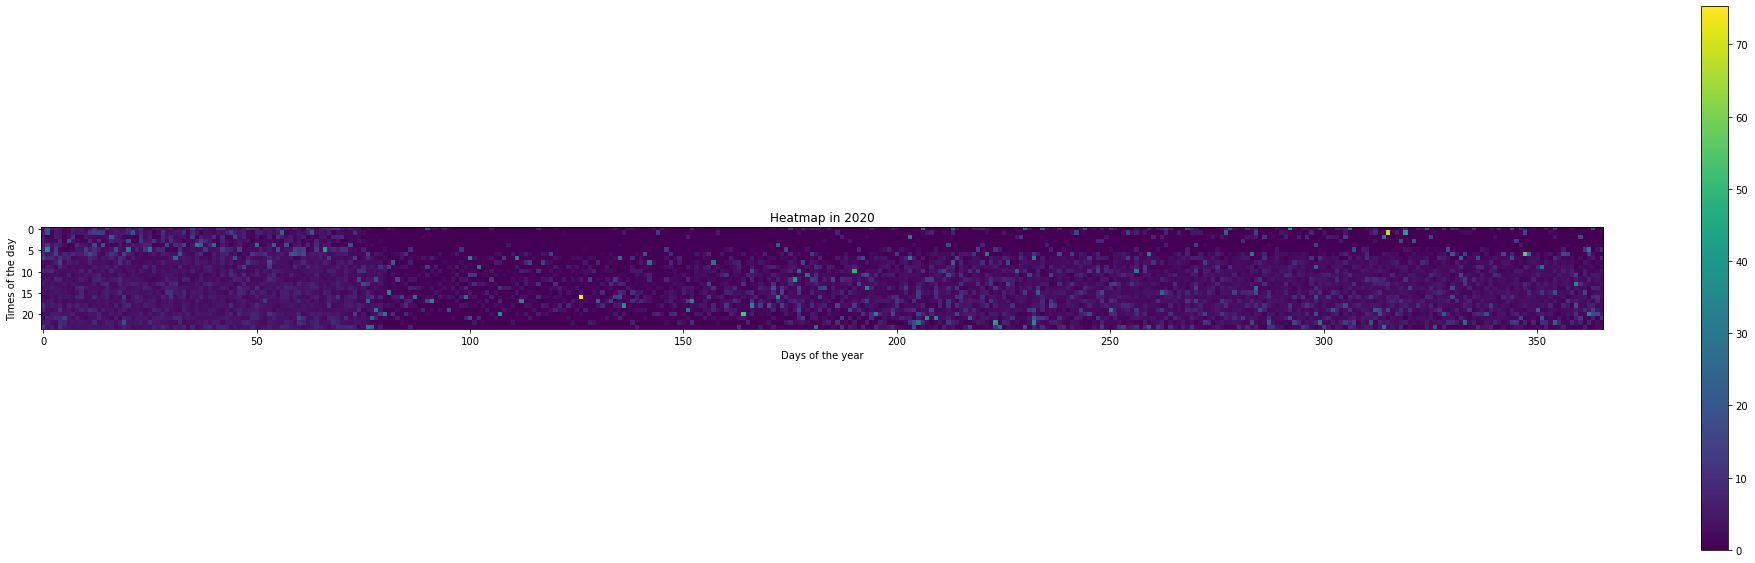

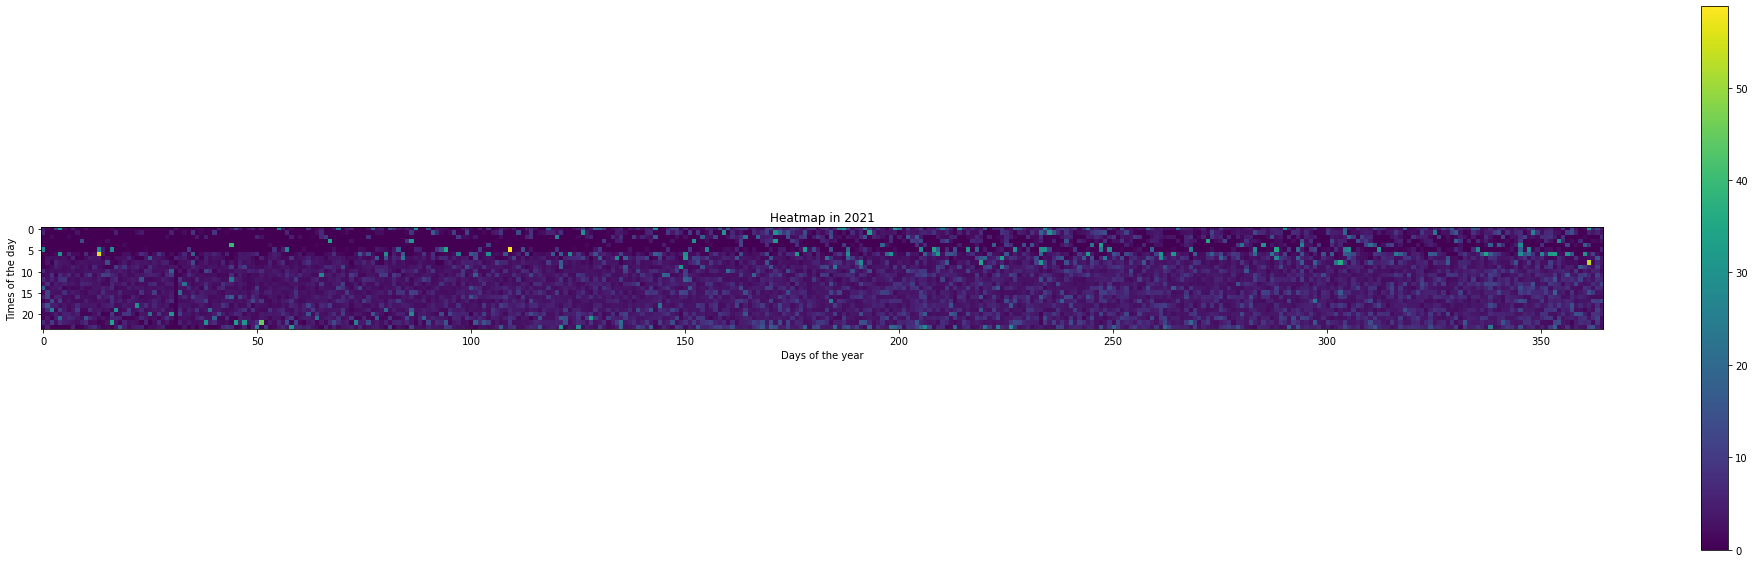

In [71]:
heatmap(df, ['pickup_hour', 'pickup_dayofyear'], 'trip_distance', 'Days of the year', 'Times of the day')

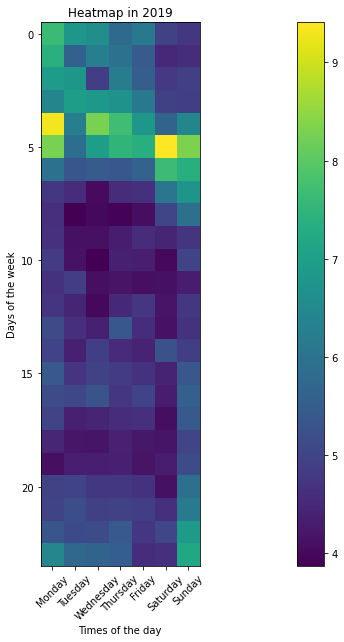

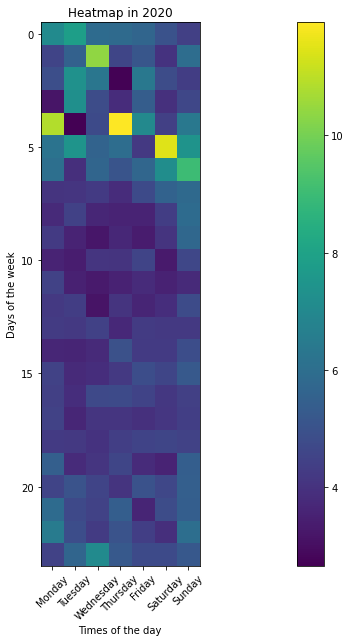

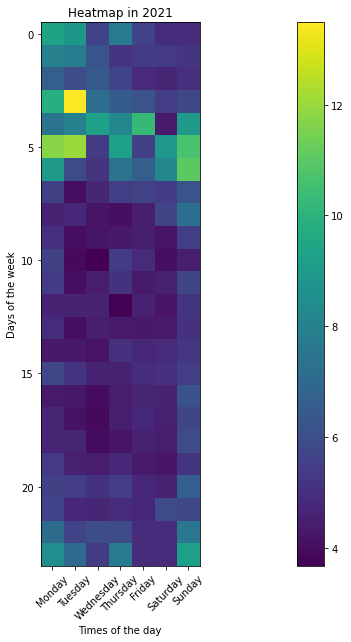

In [72]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Finally, view the average speed at different times of the day during the week.

In [101]:
def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Function that aggregates data appropriately to display a speed heatmap
    """
    
    # HERE YOUR CODE    
    values = df.groupby(group)['speed'].mean().unstack().fillna(0) 

    plt.figure(figsize=(15,20))
    plt.imshow(values)
    plt.xticks([0,1,2,3,4,5,6], columns, rotation=45)

    plt.colorbar()
#     raise NotImplementedError

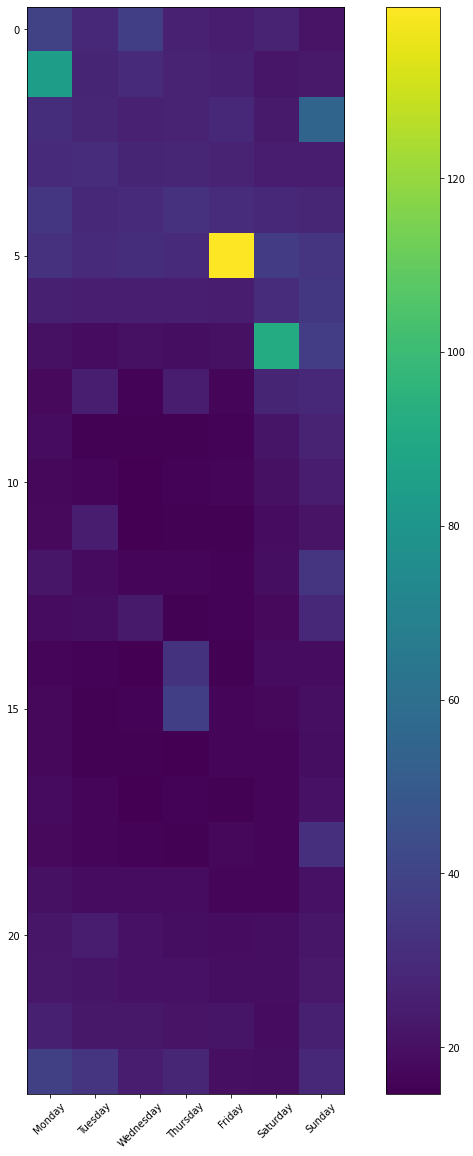

In [102]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Times of the day', 'Days of the week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Question: Which conclusions do you obtain from the heatmaps?**
    
> ANSWER

## 05. Visualize the locations of the trips

In [103]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,pickup_week,dropoff_week,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_duration,dropoff_dayofyear,pickup_dayofyear,speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,2.400,151,239,1,7.0,9.95,2019,...,1,1,0,0,1,1,6.666667,1,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1.0,3.056,148,137,2,8.5,9.80,2019,...,1,1,0,1,1,1,8.116667,1,1,22.590554
2000,2019-01-01 00:50:22,2019-01-01 01:19:44,2.0,12.320,264,264,1,26.0,31.30,2019,...,1,1,0,1,1,1,29.366667,1,1,25.171396
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1.0,2.240,249,164,1,7.5,11.40,2019,...,1,1,0,1,1,1,8.450000,1,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2.0,1.072,162,137,2,4.0,5.30,2019,...,1,1,0,0,1,1,3.000000,1,1,21.440000


The data only has the ID of a location, so you need to add the latitude and longitude.

This information is saved in *data/geodata/taxi_zones.shp*.

The next cells can be understood as a black box.

In [105]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [115]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [116]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


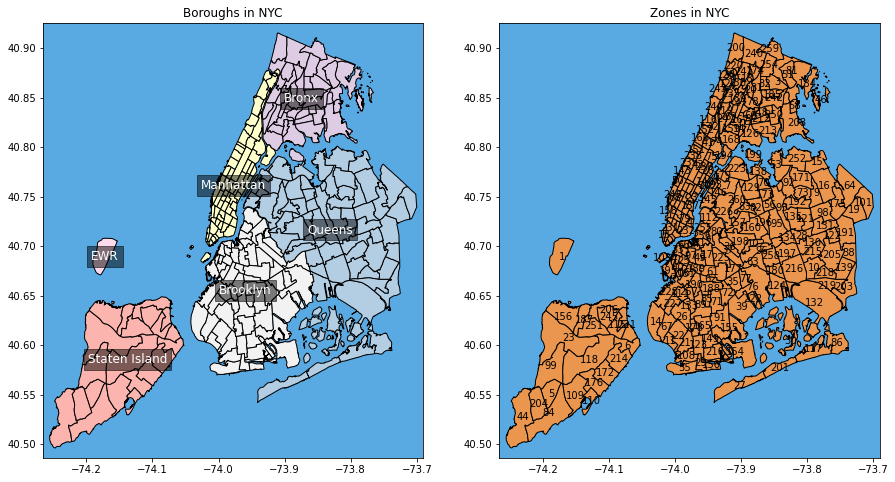

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)

ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Now you have two dataframes that you need to join. Use the *pd.merge* function to add the longitude and latitude to the *df* dataframe:

In [530]:
# HERE YOUR CODE
merge = pd.merge(df, df_loc,left_on = 'PULocationID', right_on = 'LocationID')

In [531]:
merge.shape

(131765, 29)

In [532]:
df_loc.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'longitude', 'latitude'],
      dtype='object')

## 06. Which are the areas/zones with more pick-up and drop-off?

In this section, you have to visualize the areas where taxis are most used.

The first step is to sort and save in a variable the most common places in the pick-up and drop-off.

The variables *top_pu* and *top_do* contains a dataframe with columns: 'year', 'PULocationID', and 'count'.

In [ ]:
# Pick-up
# HERE YOUR CODE
top_pu = ...
top_pu.columns = ['year', 'PULocationID', 'count']

# Drop-off
# HERE YOUR CODE
top_do = ...
top_do.columns = ['year', 'DOLocationID', 'count']

Print the 5 most frequent zones per year and in each case (pick-up and drop-off).

In [ ]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    
    """
    Function that print the most common zones by year
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
show_top_n(top_pu, 'PULocationID', df_loc)

In [ ]:
show_top_n(top_do, 'DOLocationID', df_loc)

**Let's see with a heat map which are the most common zones**

In [ ]:
for year in YEARS:
    
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'count']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

**Question: Why do you think the Manhattan area has more trips?**

> ANSWER

## 07. Hospitals

How has the travel destination changed? Are more people going to hospitals?

In the next cell, there is a DataFrame with the most important hospitals in New York and their locations.

In [533]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Use the latitude and longitude of each hospital and the latitude and longitude of the zone (information in *merge* dataframe) to see the distribution of the hospitals "on the map".

To do this, use a scatter plot. It will be better understood if the points are transparent (parameter *alpha*).

Also, remember how the longitude and latitude data have to be plotted in the figure.

Then repeat the same scatter plot but separated by years.

In [534]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'total_amount', 'year', 'pickup_month', 'dropoff_month',
       'pickup_week', 'dropoff_week', 'pickup_hour', 'dropoff_hour',
       'pickup_day', 'dropoff_day', 'trip_duration', 'dropoff_dayofyear',
       'pickup_dayofyear'],
      dtype='object')

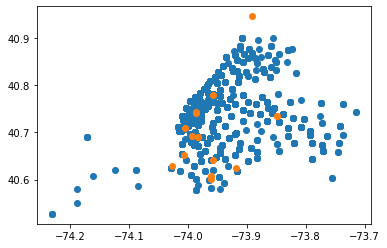

In [537]:
plt.scatter(merge.longitude,merge.latitude)
plt.scatter(hospitals.Longitude,hospitals.Latitude)

In [ ]:
def scatter_locations(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations"""
    # HERE YOUR CODE
    # 
    raise NotImplementedError

In [ ]:
scatter_locations(merge, hospitals)

In [ ]:
def scatter_locations_per_year(merge, hospitals):
    """Function showing the distribution of hospitals and taxi destinations per year"""
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
scatter_locations_per_year(merge, hospitals)

**Question: Do you see any behavior?**

>ANSWER

To find out how trips to hospitals have changed, you need to detect in which zone is each hospital.

To do it, you need to calculate the distances between the hospitals and the zones. 

Do not calculate the distance point-to-point, but matrix-wise.

In [539]:
from scipy.spatial import distance_matrix

In [540]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# HERE YOUR CODE
dist = distance_matrix(hospitals_loc, loc) # calculo de la distancia matricial o distancia euclineana en base a la longitud y latitud
# Se puede hacer con un for pero usamos la función distance_matrix


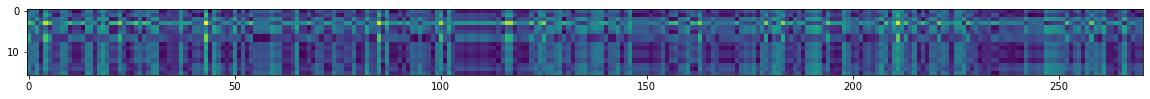

In [541]:
# Distances as an image
plt.figure(figsize=(20, 5))
plt.imshow(dist) # Acá se observa las distancias entre cada hospital con cada zona

Find a way to locate the nearest sector based on distances.

In [543]:
# HERE YOUR CODE
hospitals_locations = dist.argmin(1) # Acá se calcula la distancia minima para saber a que zona pertenece
hospitals['LocationID'] = hospitals_locations

In [544]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,216
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,243
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,130
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,207
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,13


Now that you know the zone of each hospital, visualize how many trips are related to them.

You will assume that all trips in the zone go to the hospital.

Make a single figure with two bar plots showing the number of trips for each year and the % of total trips.

In [ ]:
def trips_hospitals(df, hospitals_locations):
    """
    Function that displays a single figure with two bar plots showing the number of trips for each year and the % of total trips.
    """
    # HERE YOUR CODE
    raise NotImplementedError

In [ ]:
trips_hospitals(df, hospitals_locations)

## 08. Curiosity killed the cat

In the **first part** you must view and comment on the examples you have removed, such as very long distances, very short distances...

In the **second part** you are free to choose and make visualizations that bring you extra information that has not been seen before.

In [ ]:
### Analyze and delete outliers in "trip_duration" with boxplot to the post procesing
data = df.trip_duration
q3, q1 = np.percentile(data, [75, 25])
print ("q3", q3)
print ("q1", q1)
print (len(data[data<q1]))
print (len(data[(data>=q1) & (data<=q3)]))
print (len(data[data>q3]))
print (len(data))
fig = plt.figure(figsize =(20, 50)) 
plt.boxplot(data)

q3 4.864000000000001
q1 1.6
31672
67714
33060
132446


{'whiskers': [<matplotlib.lines.Line2D at 0x1b690d6bc40>,
 'caps': [<matplotlib.lines.Line2D at 0x1b690d7a220>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b690d6b970>],
 'medians': [<matplotlib.lines.Line2D at 0x1b690d7a7c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b690d7aa90>],
 'means': []}

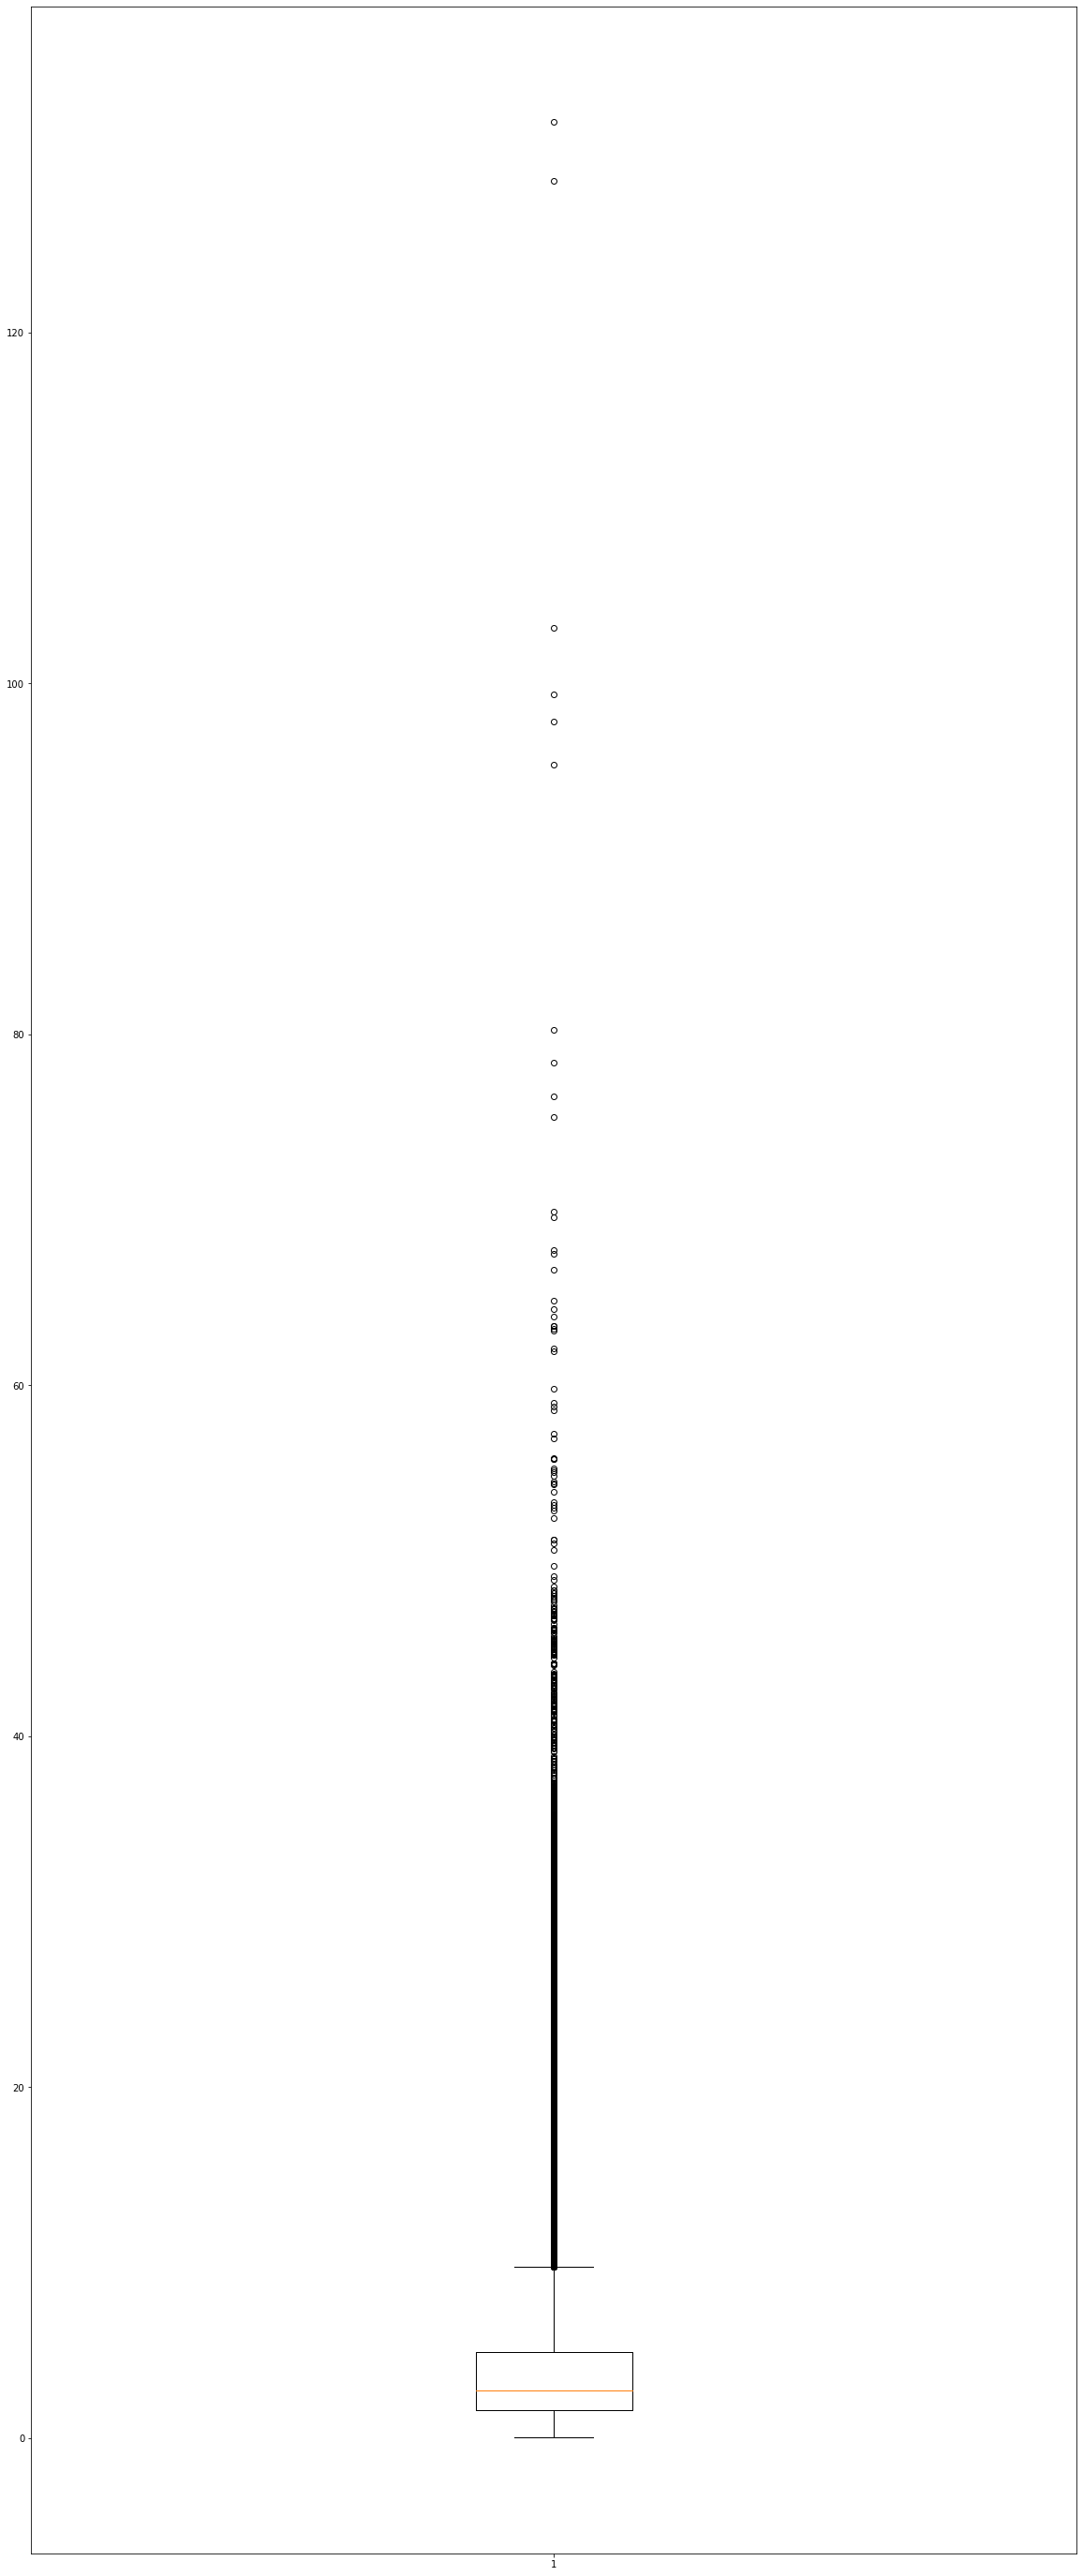

In [140]:
### Analyze and delete outliers in "trip_distance" with boxplot to the post procesing
data = df.trip_distance
q3, q1 = np.percentile(data, [75, 25])
print ("q3", q3)
print ("q1", q1)
print (len(data[data<q1]))
print (len(data[(data>=q1) & (data<=q3)]))
print (len(data[data>q3]))
print (len(data))
fig = plt.figure(figsize =(20, 50)) 
plt.boxplot(data)

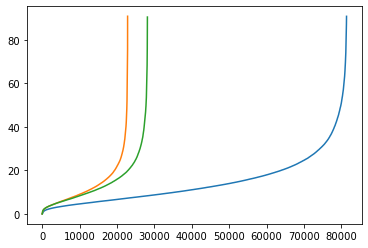

In [189]:
# Evaluate the data of the trip_duration column
plt.plot(sorted(df[(df['year']==2019)]['trip_duration'].values))
plt.plot(sorted(df[(df['year']==2020)]['trip_duration'].values))
plt.plot(sorted(df[(df['year']==2021)]['trip_duration'].values))

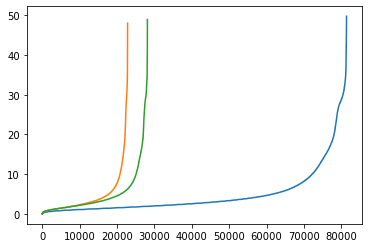

In [188]:
# Evaluate the data of the trip_distance column
plt.plot(sorted(df[(df['year']==2019)]['trip_distance'].values))
plt.plot(sorted(df[(df['year']==2020)]['trip_distance'].values))
plt.plot(sorted(df[(df['year']==2021)]['trip_distance'].values))

## 09. Report

Based on the data exploration you have done throughout this notebook, make a short report summarizing and justifying all the changes that have arisen due to covid.

In [ ]:
# Entrega 6 de Noviembre